# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face Mask Segmentation
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Change current working directory to project folder (1 mark)

In [0]:
import os
os.getcwd() 
os.chdir('/content/drive/My Drive/Colab Notebooks') 


### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [0]:
import numpy as np
data = np.load('/content/drive/My Drive/Colab Notebooks/images.npy', allow_pickle=True)

### Check one sample from the loaded "images.npy" file  (2 marks)
Hint - print data[10][1] 

In [4]:
data.shape

(409, 2)

In [5]:
data[10][1]

[{'imageHeight': 337,
  'imageWidth': 600,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.48, 'y': 0.10385756676557864},
   {'x': 0.7716666666666666, 'y': 0.6795252225519288}]}]

### Set image dimensions   (1 mark)
- Initialize image height, image width with value: 224 

In [0]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array  (1 mark)

In [8]:
X_train.shape

(409, 224, 224, 3)

In [9]:
masks.shape

(409, 224, 224)

In [10]:
X_train.dtype

dtype('float64')

### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.83529413 -0.72549021 -0.65490198]
  [-0.82745099 -0.70980394 -0.63921571]
  [-0.81176472 -0.68627453 -0.62352943]
  ...
  [-0.87450981 -0.81960785 -0.77254903]
  [-0.87450981 -0.81960785 -0.75686276]
  [-0.86666667 -0.79607844 -0.73333335]]

 [[-0.8509804  -0.7019608  -0.65490198]
  [-0.8509804  -0.7019608  -0.65490198]
  [-0.83529413 -0.68627453 -0.63921571]
  ...
  [-0.86666667 -0.81176472 -0.7647059 ]
  [-0.84313726 -0.78823531 -0.72549021]
  [-0.83529413 -0.7647059  -0.70980394]]

 [[-0.84313726 -0.67843139 -0.63921571]
  [-0.83529413 -0.67058825 -0.63137257]
  [-0.84313726 -0.67843139 -0.63921571]
  ...
  [-0.85882354 -0.80392158 -0.75686276]
  [-0.81960785 -0.7647059  -0.70980394]
  [-0.81176472 -0.74117649 -0.68627453]]

 ...

 [[-0.71764708 -0.59215689 -0.52941179]
  [-0.7019608  -0.57647061 -0.51372552]
  [-0.69411767 -0.59215689 -0.52156866]
  ...
  [-0.90588236 -0.81960785 -0.77254903]
  [-0.9137255  -0.82745099 -0.78039217]
  [-0.90588236 -0.81960785 -0.77254903]]

 [

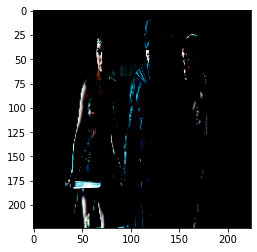

In [11]:
from matplotlib import pyplot
n = 15
print(X_train[n])
pyplot.imshow(X_train[n])

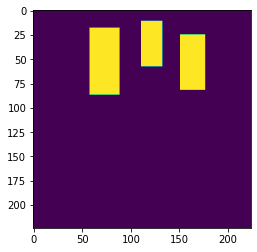

In [12]:
pyplot.imshow(masks[n])

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_1_relu").output
    block2 = model.get_layer("conv_pw_3_relu").output
    block3 = model.get_layer("conv_pw_5_relu").output
    block4 = model.get_layer("conv_pw_11_relu").output
    block5 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block5), block4])
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT,IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)

### Call the create_model function

In [29]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________


### Define dice coefficient function (5 marks)
- Create a function to calculate dice coefficient


In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

### Define loss

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (2 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [0]:
from tensorflow.keras.optimizers import Adam
model.compile(loss=loss, optimizer='adam', metrics=[dice_coefficient])

### Define checkpoint and earlystopping

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model (2 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [35]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
model.fit(X_train,masks, epochs=2, callbacks=[checkpoint, reduce_lr, stop],batch_size=1)

Epoch 1/2
409/409 [==============================] - ETA: 0s - loss: 0.8405 - dice_coefficient: 0.6047
Epoch 00001: loss improved from inf to 0.84049, saving model to model-0.84.h5
409/409 [==============================] - 70s 171ms/step - loss: 0.8405 - dice_coefficient: 0.6047 - lr: 0.0010
Epoch 2/2
409/409 [==============================] - ETA: 0s - loss: 0.7035 - dice_coefficient: 0.6541
Epoch 00002: loss improved from 0.84049 to 0.70350, saving model to model-0.70.h5
409/409 [==============================] - 71s 173ms/step - loss: 0.7035 - dice_coefficient: 0.6541 - lr: 0.0010


### Get the predicted mask for a sample image   (3 marks)

In [0]:
n = 10
sample_image = X_train[n]
pred_masks=model.predict(x=np.array([sample_image]))[0]

### Impose the mask on the image (3 marks)

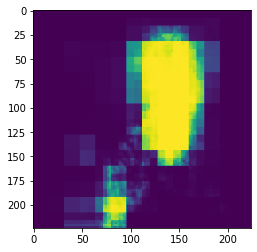

In [46]:
pyplot.imshow(pred_masks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


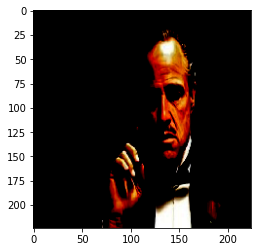

In [47]:
n = 10
pyplot.imshow(X_train[n])